In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import glob
import h5py
import fsspec
from pyproj import Proj, CRS
import matplotlib.pyplot as plt
import shapely.wkt as wkt
import rasterio
from rasterio.crs import CRS
from rasterio.transform import from_origin
from rasterio import merge
import folium
from folium import plugins
import rioxarray
import matplotlib as mpl
import sys
sys.path.append('../../')
from src.cslc_utils import read_cslc, cslc_info, rasterWrite, custom_merge, colorize, getbasemaps

import warnings
warnings.filterwarnings('ignore')

In [3]:
data_dir = 's3://opera-provisional-products/CSLC/Ridgecrest/Descending'
burst_id = ['t071_151217_iw3', 't071_151217_iw2', 't071_151218_iw3','t071_151218_iw2', 't071_151219_iw3','t071_151219_iw2', 't071_151220_iw2']
#burst_id = ['t071_151218_iw3', 't071_151218_iw2']
date = ['20190704', '20190716']
save_fn = f'Ridgecrest_{date[1]}-{date[0]}_{burst_id[0][:4]}.tif'

In [4]:
# Read before and after event dataset 
before = []; after = []  

for id in burst_id:
    path_h5 = f'{data_dir}/{id}/{date[0]}/{id}_{date[0]}.h5' 
    dat = read_cslc(path_h5)
    before.append(dat)

for id in burst_id:
    path_h5 = f'{data_dir}/{id}/{date[1]}/{id}_{date[1]}.h5' 
    dat = read_cslc(path_h5)
    after.append(dat)

Streaming: s3://opera-provisional-products/CSLC/Ridgecrest/Descending/t071_151216_iw3/20190704/t071_151216_iw3_20190704.h5
Streaming: s3://opera-provisional-products/CSLC/Ridgecrest/Descending/t071_151217_iw3/20190704/t071_151217_iw3_20190704.h5
Streaming: s3://opera-provisional-products/CSLC/Ridgecrest/Descending/t071_151217_iw2/20190704/t071_151217_iw2_20190704.h5
Streaming: s3://opera-provisional-products/CSLC/Ridgecrest/Descending/t071_151218_iw3/20190704/t071_151218_iw3_20190704.h5
Streaming: s3://opera-provisional-products/CSLC/Ridgecrest/Descending/t071_151218_iw2/20190704/t071_151218_iw2_20190704.h5
Streaming: s3://opera-provisional-products/CSLC/Ridgecrest/Descending/t071_151219_iw3/20190704/t071_151219_iw3_20190704.h5
Streaming: s3://opera-provisional-products/CSLC/Ridgecrest/Descending/t071_151219_iw2/20190704/t071_151219_iw2_20190704.h5
Streaming: s3://opera-provisional-products/CSLC/Ridgecrest/Descending/t071_151220_iw2/20190704/t071_151220_iw2_20190704.h5
Streaming: s3://

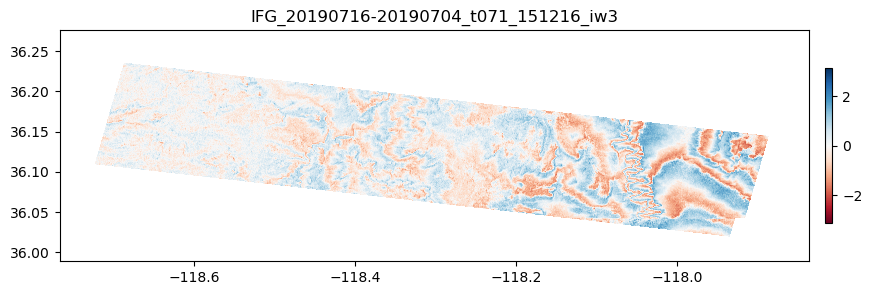

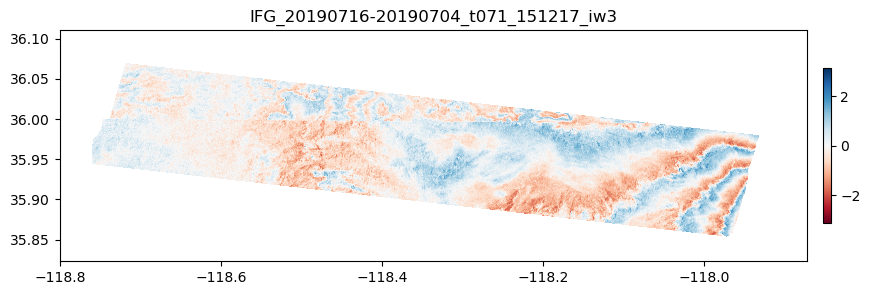

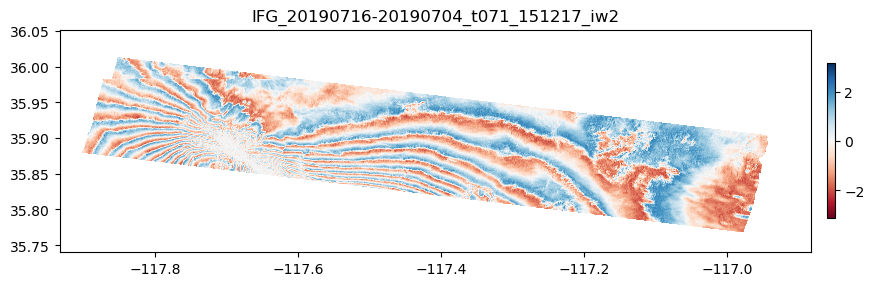

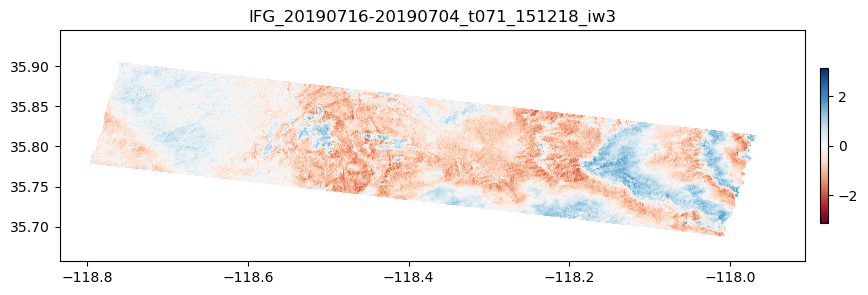

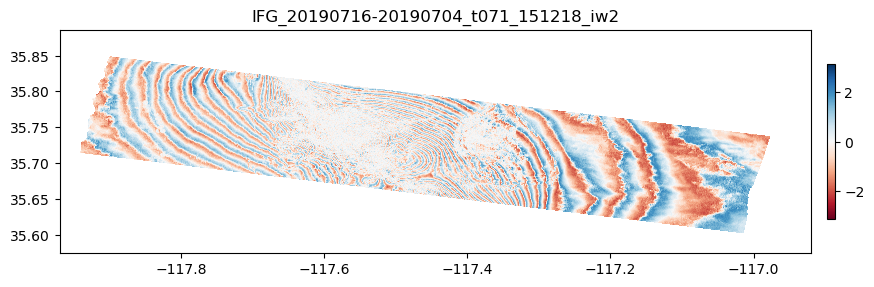

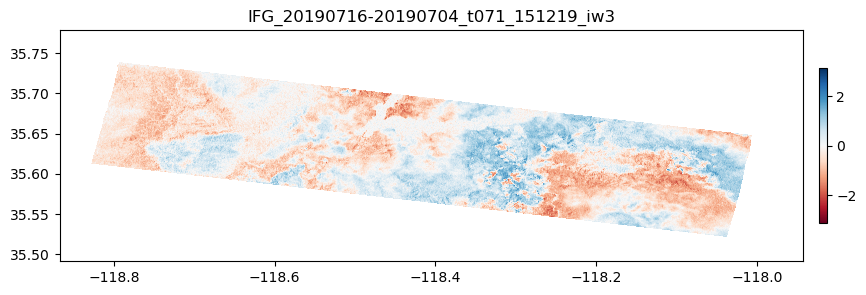

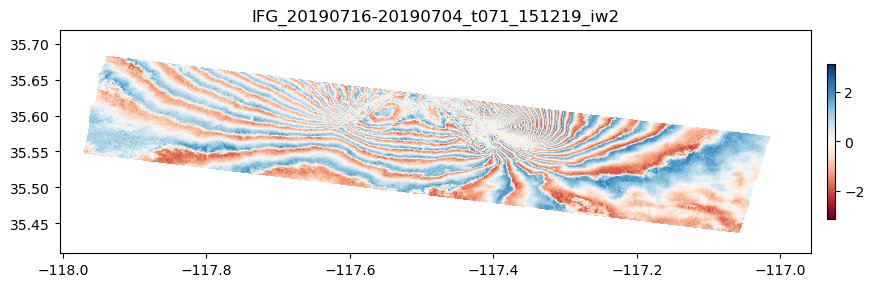

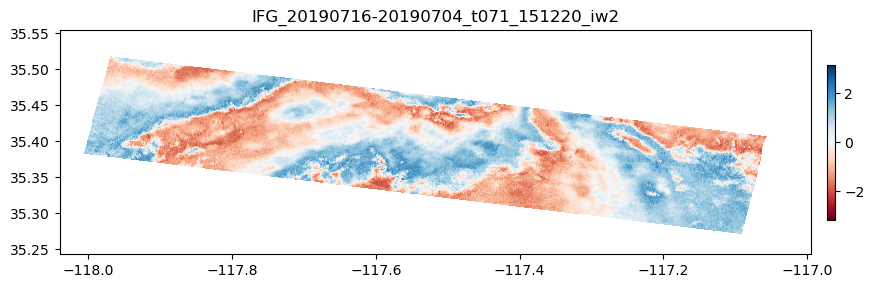

In [5]:
%matplotlib inline
from shapely.ops import unary_union
new_cslc_poly= []

for i, id in enumerate(burst_id):
    xcoor, ycoor, dx, dy, epsg, bounding_polygon, orbit_direction = cslc_info(f'{data_dir}/{burst_id[i]}/{date[0]}/{burst_id[i]}_{date[0]}.h5')
    cslc_poly = wkt.loads(bounding_polygon)
    bbox = [cslc_poly.bounds[0], cslc_poly.bounds[2], cslc_poly.bounds[1], cslc_poly.bounds[3]]

    if i == 0:
        new_cslc_poly= cslc_poly
    else:
        new_cslc_poly= unary_union([new_cslc_poly,cslc_poly])

    ifg = after[i] * np.conj(before[i])
    fig, ax = plt.subplots(figsize=(10,3))
    cax = ax.imshow(np.angle(ifg), cmap='RdBu',interpolation=None, origin='upper',extent=bbox, vmin=-np.pi, vmax=np.pi)
    plt.colorbar(cax,orientation='vertical',fraction=0.01,pad=0.02)
    ax.set_title(f'IFG_{date[1]}-{date[0]}_{burst_id[i]}',fontsize=12)

    transform = from_origin(xcoor[0],ycoor[0],dx,np.abs(dy))
    rasterWrite(f'ifg_{id}.tif',np.angle(ifg),transform,epsg,dtype=rasterio.float32)



In [6]:
# Merge geotiff files with rasterio
ifg_files = [(f'ifg_{id}.tif') for id in burst_id]
ifg_files_to_mosaic = []

for ref_file in ifg_files:
    src = rasterio.open(ref_file)
    ifg_files_to_mosaic.append(src)

dest, output_transform=merge.merge(ifg_files_to_mosaic, method=custom_merge)
with rasterio.open(ifg_files[0]) as src:
        out_meta = src.meta.copy() 
out_meta.update({"driver": "GTiff",
                 "height": dest.shape[1],
                 "width": dest.shape[2],
                 "transform": output_transform})
with rasterio.open(save_fn, "w", **out_meta) as dest1:
        dest1.write(dest)

# print(dest.shape)

In [7]:
# Read the merged raster file
src = rioxarray.open_rasterio(save_fn)
merged_ifg = src.rio.reproject("EPSG:4326")             # Folium maps are in EPSG:4326

# Downsample for folium visualization and attach RGBA color to numpy
colored_merged_ifg = colorize(merged_ifg[0][::8][::8], 'jet')

In [ ]:
# Initialize Folium basemap and define bounding box
new_bbox = [new_cslc_poly.bounds[0], new_cslc_poly.bounds[2], new_cslc_poly.bounds[1], new_cslc_poly.bounds[3]]
xmid =(new_bbox[0]+new_bbox[1])/2 ; ymid = (new_bbox[2]+new_bbox[3])/2
m = folium.Map(location=[ymid, xmid], zoom_start=10, tiles='Stamen Terrain', show=True)

# Add custom basemaps
basemaps = getbasemaps()
for basemap in basemaps:
    basemaps[basemap].add_to(m)

# Overlay merged interferogram on a basemap
folium.raster_layers.ImageOverlay(colored_merged_ifg, 
                                        opacity=0.6, 
                                        bounds=[[new_bbox[2],new_bbox[0]],[new_bbox[3],new_bbox[1]]],
                                        interactive=False,
                                        name='Ridgecrest',
                                        show=True).add_to(m)

#layer Control
m.add_child(folium.LayerControl())

# Add fullscreen button
plugins.Fullscreen().add_to(m)

#Add inset minimap image
minimap = plugins.MiniMap(width=300, height=300)
m.add_child(minimap)

#Mouse Position
fmtr = "function(num) {return L.Util.formatNum(num, 3) + ' º ';};"
plugins.MousePosition(position='bottomright', separator=' | ', prefix="Lat/Lon:",
                     lat_formatter=fmtr, lng_formatter=fmtr).add_to(m)

#Display
m